In [273]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/building-extraction/image1.tif
/kaggle/input/building-extraction/img1_ground_truth.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.15.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.17.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.14.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.9.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.3.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.4.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.0.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.16.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.20.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.19.tif
/kaggle/input/building-extraction/truth_images/truth_images/truth_images.1.tif
/kaggle/input/building-e

In [274]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from skimage import io as io

In [275]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [276]:
image_directory = '/kaggle/input/building-extraction/images/images/'
mask_directory = '/kaggle/input/building-extraction/truth_images/truth_images/'

In [277]:
'''name = 'images.33.tif'
image = io.imread(image_directory+name)
image = image.reshape(-1)
print(image)'''
#plt.imshow(image)

"name = 'images.33.tif'\nimage = io.imread(image_directory+name)\nimage = image.reshape(-1)\nprint(image)"

In [278]:
WIDTH = 256
HEIGHT = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

In [279]:
images = os.listdir(image_directory)
images.sort()
print(images)

['images.0.tif', 'images.1.tif', 'images.10.tif', 'images.11.tif', 'images.12.tif', 'images.13.tif', 'images.14.tif', 'images.15.tif', 'images.16.tif', 'images.17.tif', 'images.18.tif', 'images.19.tif', 'images.2.tif', 'images.20.tif', 'images.3.tif', 'images.4.tif', 'images.5.tif', 'images.6.tif', 'images.7.tif', 'images.8.tif', 'images.9.tif']


In [280]:
images = os.listdir(image_directory)
images.sort()
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    #print(image_name)
    if (image_name.split('.')[2] == 'tif'):
        #print(image_directory+image_name)
        image = io.imread(image_directory+image_name)
        #image = image.reshape(-1)
        image = Image.fromarray(image)
        image = image.resize((WIDTH, HEIGHT))
        image_dataset.append(np.array(image))

In [281]:
#print(image_dataset)

In [282]:
masks = os.listdir(mask_directory)
masks.sort()
print(masks)

['truth_images.0.tif', 'truth_images.1.tif', 'truth_images.10.tif', 'truth_images.11.tif', 'truth_images.12.tif', 'truth_images.13.tif', 'truth_images.14.tif', 'truth_images.15.tif', 'truth_images.16.tif', 'truth_images.17.tif', 'truth_images.18.tif', 'truth_images.19.tif', 'truth_images.2.tif', 'truth_images.20.tif', 'truth_images.3.tif', 'truth_images.4.tif', 'truth_images.5.tif', 'truth_images.6.tif', 'truth_images.7.tif', 'truth_images.8.tif', 'truth_images.9.tif']


In [283]:
masks = os.listdir(mask_directory)
masks.sort()
for i, image_name in enumerate(masks):
    if (image_name.split('.')[2] == 'tif'):
        image = io.imread(mask_directory+image_name)
        #image = image.reshape(-1)
        image = Image.fromarray(image)
        image = image.resize((WIDTH, HEIGHT))
        mask_dataset.append(np.array(image))

In [284]:
#print(mask_dataset)

In [285]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [286]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.1, random_state = 0)

In [287]:
#print(X_train)

In [288]:
#print(y_train)

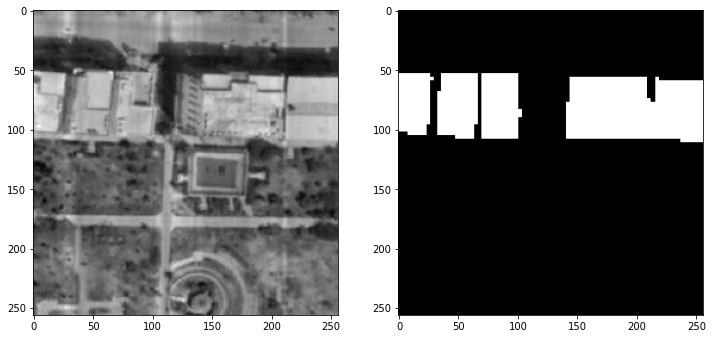

In [289]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
#plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.imshow(X_train[image_number],cmap = 'gray')
plt.subplot(122)
#plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.imshow(y_train[image_number], cmap='gray')
plt.show()

In [290]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [291]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_399 (Conv2D)             (None, 256, 256, 16) 160         input_22[0][0]                   
__________________________________________________________________________________________________
dropout_189 (Dropout)           (None, 256, 256, 16) 0           conv2d_399[0][0]                 
__________________________________________________________________________________________________
conv2d_400 (Conv2D)             (None, 256, 256, 16) 2320        dropout_189[0][0]                
___________________________________________________________________________________________

In [292]:
history = model.fit(X_train, y_train, 
                    batch_size = 10, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/50
2/2 [==============================] - 10s 4s/step - loss: 0.6916 - accuracy: 0.4007 - val_loss: 0.6710 - val_accuracy: 0.8213
Epoch 2/50
2/2 [==============================] - 7s 3s/step - loss: 0.6563 - accuracy: 0.7120 - val_loss: 0.5667 - val_accuracy: 0.8213
Epoch 3/50
2/2 [==============================] - 7s 3s/step - loss: 0.3849 - accuracy: 0.7102 - val_loss: 0.0180 - val_accuracy: 0.8213
Epoch 4/50
2/2 [==============================] - 7s 3s/step - loss: 0.0792 - accuracy: 0.7137 - val_loss: 0.0461 - val_accuracy: 0.8209
Epoch 5/50
2/2 [==============================] - 7s 3s/step - loss: 0.1415 - accuracy: 0.7142 - val_loss: 0.0163 - val_accuracy: 0.8213
Epoch 6/50
2/2 [==============================] - 8s 3s/step - loss: 0.0362 - accuracy: 0.7144 - val_loss: 0.0509 - val_accuracy: 0.8213
Epoch 7/50
2/2 [==============================] - 7s 3s/step - loss: 0.0309 - accuracy: 0.7147 - val_loss: 0.1317 - val_accuracy: 0.8213
Epoch 8/50
2/2 [========================

In [293]:
model.save('Area1_test.hdf5')

In [294]:
# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

1/1 [==============================] - 0s 251ms/step - loss: 0.0094 - accuracy: 0.8213
Accuracy =  82.13297724723816 %


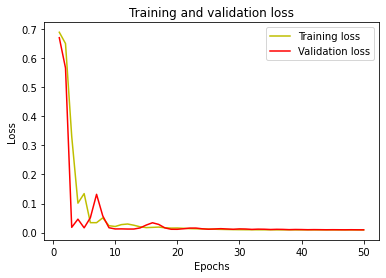

In [295]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [296]:
#acc = history.history['acc']
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
val_acc = history.history['val_accuracy']


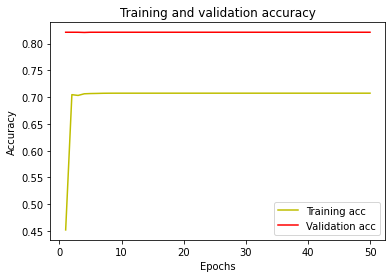

In [297]:
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [298]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.0


In [299]:
#Predict on a few images
model = get_model()
model.load_weights('Area1_test.hdf5') #Trained for 50 epochs and then additional 100
#model.load_weights('mitochondria_gpu_tf1.4.hdf5')  #Trained for 50 epochs

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_418 (Conv2D)             (None, 256, 256, 16) 160         input_23[0][0]                   
__________________________________________________________________________________________________
dropout_198 (Dropout)           (None, 256, 256, 16) 0           conv2d_418[0][0]                 
__________________________________________________________________________________________________
conv2d_419 (Conv2D)             (None, 256, 256, 16) 2320        dropout_198[0][0]                
___________________________________________________________________________________________

In [300]:
test_img_number = random.randint(0, len(X_test)-1)
print(test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

2


In [301]:
test_img_other = cv2.imread('/kaggle/input/building-extraction/images/images/images.8.tif', 0)
#test_img_other = cv2.imread('data/test_images/img8.tif', 0)
test_img_other_norm = np.expand_dims(normalize(np.array(test_img_other), axis=1),2)
test_img_other_norm=test_img_other_norm[:,:,0][:,:,None]
test_img_other_input=np.expand_dims(test_img_other_norm, 0)

In [302]:
#Predict and threshold for values above 0.5 probability
#Change the probability threshold to low value (e.g. 0.05) for watershed demo.
prediction_other = (model.predict(test_img_other_input)[0,:,:,0] > 0.5).astype(np.uint8)

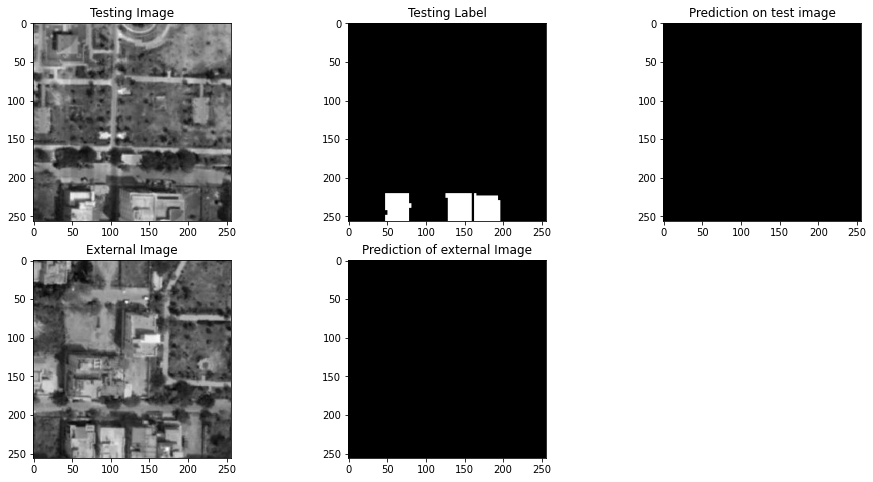

In [303]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.subplot(234)
plt.title('External Image')
plt.imshow(test_img_other, cmap='gray')
plt.subplot(235)
plt.title('Prediction of external Image')
plt.imshow(prediction_other, cmap='gray')
plt.show()

#plt.imsave('input.jpg', test_img[:,:,0], cmap='gray')
#plt.imsave('data/results/output2.jpg', prediction_other, cmap='gray')

In [304]:
def get_model():
    return simple_unet_model(256, 256, 1)

model = get_model()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_437 (Conv2D)             (None, 256, 256, 16) 160         input_24[0][0]                   
__________________________________________________________________________________________________
dropout_207 (Dropout)           (None, 256, 256, 16) 0           conv2d_437[0][0]                 
__________________________________________________________________________________________________
conv2d_438 (Conv2D)             (None, 256, 256, 16) 2320        dropout_207[0][0]                
___________________________________________________________________________________________

In [305]:
patch_size=256

def prediction(model, image, patch_size):
    segm_img = np.zeros(image.shape[:2])  #Array with zeros to be filled with segmented values
    patch_num=1
    for i in range(0, image.shape[0], 256):   #Steps of 256
        for j in range(0, image.shape[1], 256):  #Steps of 256
            #print(i, j)
            single_patch = image[i:i+patch_size, j:j+patch_size]
            single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
            single_patch_shape = single_patch_norm.shape[:2]
            single_patch_input = np.expand_dims(single_patch_norm, 0)
            single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
            segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(single_patch_prediction, single_patch_shape[::-1])
          
            print("Finished processing patch number ", patch_num, " at position ", i,j)
            patch_num+=1
    return segm_img

In [306]:
model.load_weights('Area1_test.hdf5')

Finished processing patch number  1  at position  0 0
Finished processing patch number  2  at position  0 256
Finished processing patch number  3  at position  0 512
Finished processing patch number  4  at position  0 768
Finished processing patch number  5  at position  0 1024
Finished processing patch number  6  at position  0 1280
Finished processing patch number  7  at position  0 1536
Finished processing patch number  8  at position  256 0
Finished processing patch number  9  at position  256 256
Finished processing patch number  10  at position  256 512
Finished processing patch number  11  at position  256 768
Finished processing patch number  12  at position  256 1024
Finished processing patch number  13  at position  256 1280
Finished processing patch number  14  at position  256 1536
Finished processing patch number  15  at position  512 0
Finished processing patch number  16  at position  512 256
Finished processing patch number  17  at position  512 512
Finished processing 

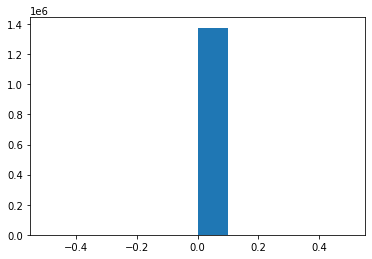

In [307]:
#Large image
large_image = cv2.imread('/kaggle/input/bw-image/input_image.tif', 0)
segmented_image = prediction(model, large_image, patch_size)
plt.hist(segmented_image.flatten())  #Threshold everything above 0

plt.imsave('segm.jpg', segmented_image, cmap='gray')

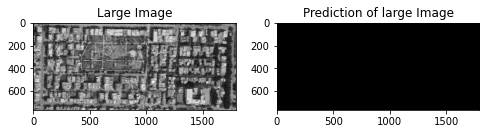

In [308]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(segmented_image, cmap='gray')
plt.show()